# Description of the mini-project

## Dataset

In this mini-project we will work with a dataset used in the *EE-490 Lab in Data Science* course. It is composed of CO2 measurements taken from a pool of 46 cheap but inaccurate sensors deployed in the city of Zurich. In addition, we also have access to temperature and humidity measurements, the altitude of the sensor as well as the average daily wind pattern for the city.

## Prior Knowledge

Measurements highly depends on the temperature, the humidity, the wind, the altitude and the level of traffic around the site. For example, a sensor that is located in a mountain with high altitude and exposed to strong winds is expected to have a much lower and uniform level of CO2 compared to another sensor that is located near the center of the city and close to a busy industrial zone exposed to high traffic activity. We also know that there is a strong dependence of the CO2 measurements on the temperature and the humidity.

## Assumption

Sensors in similar conditions are expected to have similar measurements.

## Issue

It might be the case that one sensor suddenly begins to take wrong measurements. The detection of faulty sensors is done by an external domain expert. Then, our job consists in curate the CO2 measurements for that particular sensor through our regression model.

## Goal

Fit a linear regression model to the CO2 measurements based on the aforementioned features. Do a performance evaluation between several models by comparing the fitting time and the goodness of fit.

## Proposed solution and structure

Our proposed solution can be decomposed in the following parts:

* Preprocessing: features come in different files, we need to aggregate them and make sure the data comes exempt from missing values or any defect. K-means is used to optimally group sensor that are in similar conditions, such as altitude and wind exposure.
* Faulty sensor modeling: in order to test our model's ability to fit the lost measurements, we need to model the faulty sensors. In this way we will be able to compare our prediction against the true measurements.
* Performance evaluation: compare the different models and select the most appropriate one.

In [54]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import array
from tqdm import tqdm_notebook as tqdm

## Preprocessing

### Merging CO2 measurements, temperature and humidity in a single dataframe.

In [2]:
# Load the data
CO2_measurement = pd.read_csv('data/CO2_sensor_measurements.csv', sep='\t')
zurich_average_wind = pd.read_csv('data/zurich_average_wind.csv', sep='\t')
zurich_temp_humidity= pd.read_csv('data/temperature_humidity.csv', sep='\t')
sensors_metadata = pd.read_csv('data/sensors_metadata.csv', sep='\t') 

# Some values are missing, that is why we will interpolate them by taking the average over an interval of 30min.
# We will also aggregate all the information of CO2 measurements, temperature and humidity into one single 
# dataframe for more practicality.

# interpolate CO2_measurement
CO2_measurement = CO2_measurement.interpolate().set_index('timestamp')
CO2_measurement.index = pd.to_datetime(CO2_measurement.index)
grouper = CO2_measurement.groupby([pd.Grouper(freq='30Min'), 'LocationName', 'SensorUnit_ID'])
grouper = grouper.mean()


# interpolate temperature and humidity
zurich_temp_humidity = zurich_temp_humidity.interpolate().set_index('Timestamp')
zurich_temp_humidity.index.names = ['timestamp']
zurich_temp_humidity.index = pd.to_datetime(zurich_temp_humidity.index)
zurich_temp_humidity = zurich_temp_humidity.resample('30Min').mean()

# merge the two dataframes
grouper = grouper.reset_index()
mth = pd.DataFrame()
for e in tqdm(zurich_temp_humidity.columns[::2]):
    id_ = int(e.split('.')[0])
    df = zurich_temp_humidity[['{}.temperature'.format(id_), '{}.humidity'.format(id_)]].rename(
        columns={
            '{}.temperature'.format(id_): 'temperature',
            '{}.humidity'.format(id_):'humidity'
        }
    )
    df['SensorUnit_ID'] = id_
    mth = mth.append(grouper.merge(df.reset_index(), on=['timestamp', 'SensorUnit_ID'])) 
mth = mth.set_index('timestamp')

In [3]:
mth.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,
2017-10-01 00:00:00,ZGHD,1014,595.004391,11.396667,92.440806
2017-10-01 00:30:00,ZGHD,1014,597.017879,11.303333,91.625097
2017-10-01 01:00:00,ZGHD,1014,596.487010,11.240000,91.096761
2017-10-01 01:30:00,ZGHD,1014,598.787639,11.260000,91.275734
2017-10-01 02:00:00,ZGHD,1014,595.366394,11.285000,91.003937


### Applying K-means for the altitude and wind exposure.

For the altitude: K-means will be computed based on two features of the sensor. Its altitude and its median of the CO2 measurements for the entire month.

In [33]:
# take the median of the CO2_measurements
CO2_measurements = mth[['LocationName', 'CO2']].groupby([pd.Grouper(freq='1M'), 'LocationName'])\
                    .median().reset_index().drop('timestamp', 1).set_index('LocationName')

# select only altitude from the metadata
altitude = sensors_metadata[['LocationName', 'altitude']].set_index('LocationName')

# join both features in a single dataframe
ma = CO2_measurements.join(altitude)
ma.head()

,CO2,altitude
LocationName,,
AJGR,334.785793,627.8
BSCR,475.316233,462.3
BUDF,422.793126,490.2
KBRL,410.100150,510.5
KTGM,444.395518,530.3


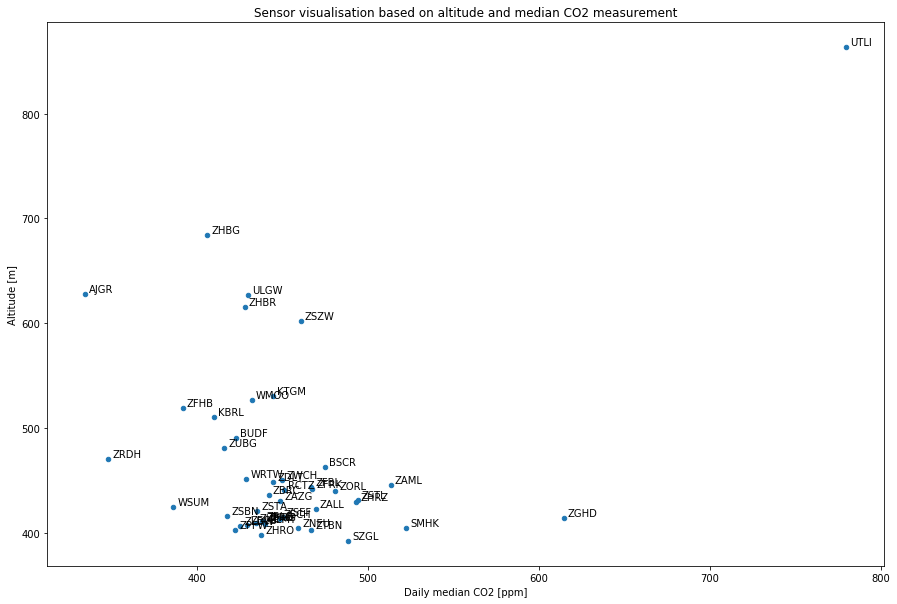

In [87]:
ax = ma.plot(x='CO2', y='altitude', kind='scatter', figsize=(15, 10))

for k, v in ma.iterrows():
    ax.annotate(k, v, xytext=(4,2), textcoords='offset points', fontsize=10)

plt.title('Sensor visualisation based on altitude and median CO2 measurement')
plt.xlabel('Daily median CO2 [ppm]')
plt.ylabel('Altitude [m]')
plt.show()

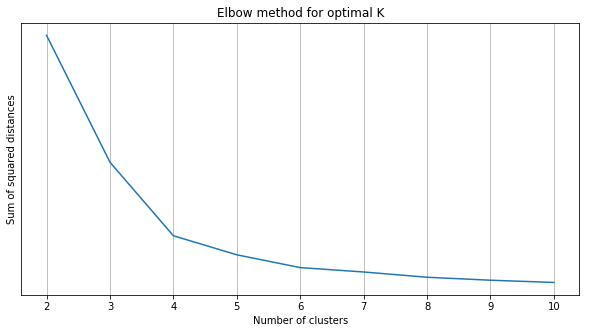

In [88]:
range_k = range(2,11)
X = ma.values
kmeans = [KMeans(i) for i in search_space]
scores = [kmeans[i].fit(X).inertia_ for i in range(len(kmeans))]

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(range_k, scores)
plt.title('Elbow method for optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.yticks([])
plt.grid()
plt.show()

In [ ]:
"""X = ma.values
range_k = range(2,11)
for k in range_k:
    cluster = KMeans(n_clusters=k)
    cluster_labels = cluster.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print('For K={}, the average silhouette score is {:1.5f}.'.format(k, silhouette_avg))"""

In [89]:
ma['altitude_cluster'] = KMeans(4).fit(X).labels_
ma.head()

,CO2,altitude,altitude_cluster
LocationName,,,
AJGR,334.785793,627.8,1
BSCR,475.316233,462.3,0
BUDF,422.793126,490.2,3
KBRL,410.100150,510.5,3
KTGM,444.395518,530.3,3
